In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
pd.set_option('display.max_columns', None)

# Load Data
df = pd.read_excel("stockist_data_with_date.xlsx")

In [16]:
df.shape

(30000, 31)

In [17]:
df.head()

,Partner_id,AIS(Air Insulated Switchgear),RMU(Ring Main Unit),PSS(Compact Sub-Stations),VCU(Vacuum Contactor Units),E-House,VCB(Vacuum Circuit Breaker),ACB(Air Circuit Breaker),MCCB(Moduled Case Circuit Breaker),SDF(Switch Disconnectors),BBT(Busbar Trunking),Modular Switches,Starter,Controller,Solar Solutions,Pump Starter and Controller,Geography,Stockist_Type,Scheme_Type,Sales_Value_Last_Period,Sales_Quantity_Last_Period,MRP,Discount_Applied,Bulk_Purchase_Tendency,Competitor_Price,Competitor_Discount,Date,Month,Year,Sales_Value_Last_Period_3M_Ago,Discount_Applied_3M_Ago
0,281_74,1,1,0,0,1,1,1,1,0,0,0,1,1,0,1,West,Retailer,Bulk Purchase,22014,2,4679,5,0,914.92,7,2024-12-10,12,2024,18426.25864,0
1,549_85,0,1,0,1,1,1,0,1,0,1,1,1,0,1,1,North,Wholesaler,Bulk Purchase,28863,2,3335,7,0,915.17,9,2025-01-04,1,2025,25648.28893,6
2,742_66,1,0,0,0,0,1,0,1,1,1,1,1,1,0,1,Central,Wholesaler,Discount,13729,2,1065,2,1,917.96,0,2022-10-23,10,2022,16393.81271,0
3,199_92,1,0,0,0,1,0,1,1,0,0,1,1,1,1,1,Central,Retailer,Bulk Purchase,22038,2,1244,5,1,918.68,1,2022-09-17,9,2022,25221.93771,0
4,412_67,1,1,0,1,0,1,1,1,0,0,1,0,0,1,0,Central,Wholesaler,Loyalty,26075,2,4604,2,0,919.33,3,2023-03-23,3,2023,27523.66971,0


In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Ensure Date column is properly converted to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # 'coerce' will convert invalid dates to NaT

# Drop rows with invalid dates if any
df = df.dropna(subset=['Date'])

# Sort by date
df = df.sort_values(by='Date')

# Extract relevant product categories (using your original column names)
expected_product_columns = [
    'AIS(Air Insulated Switchgear)', 'RMU(Ring Main Unit)', 
    'PSS(Compact Sub-Stations)', 'VCU(Vacuum Contactor Units)', 
    'E-House', 'VCB(Vacuum Circuit Breaker)', 
    'ACB(Air Circuit Breaker)', 'MCCB(Moduled Case Circuit Breaker)', 
    'SDF(Switch Disconnectors)', 'BBT(Busbar Trunking)', 
    'Modular Switches', 'Starter', 'Controller', 
    'Solar Solutions', 'Pump Starter and Controller'
]

# Find which of these columns actually exist in the dataframe
product_columns = [col for col in expected_product_columns if col in df.columns]

# Create Product_id based on which product has value 1
df['Product_id'] = df[product_columns].idxmax(axis=1)

# Selecting necessary columns
df = df[['Partner_id', 'Product_id', 'Date', 'MRP', 'Sales_Quantity_Last_Period', 
         'Discount_Applied', 'Geography', 'Competitor_Price']].dropna()

# Rename columns
df.rename(columns={
    'MRP': 'Price', 
    'Sales_Quantity_Last_Period': 'Demand', 
    'Discount_Applied': 'Discount'
}, inplace=True)

# Filter valid data
df = df[(df['Price'] > 0) & (df['Demand'] > 0)]

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split


def prepare_data(df):
    """Prepare and clean the input dataframe with proper date handling"""
    # Convert and validate dates
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date']).sort_values('Date')
    
    # Create proper monthly index (ensuring correct period conversion)
    df['YearMonth'] = pd.to_datetime(df['Date'].dt.to_period('M').astype(str))

    # Set as datetime index
    df.set_index('YearMonth', inplace=True)


    
    # Aggregate to monthly level
    monthly_df = df.groupby(['Product_id', 'Geography', 'YearMonth']).agg({
        'Demand': 'sum',
        'Price': 'mean',
        'Competitor_Price': 'mean',
        'Discount': 'mean'
    }).reset_index()
    
    # Log transformations with proper handling
    for col in ['Demand', 'Price', 'Competitor_Price']:
        monthly_df[f'Log_{col}'] = np.log1p(monthly_df[col])  # Using log1p to handle zeros
    
    return monthly_df.dropna()

In [20]:
df

,Partner_id,Product_id,Date,Price,Demand,Discount,Geography,Competitor_Price
22601,22602_67,RMU(Ring Main Unit),2020-03-05,4227,76,3,East,4195.81
2227,02228_86,VCU(Vacuum Contactor Units),2020-03-05,3432,8,4,North,1360.15
29628,29629_69,AIS(Air Insulated Switchgear),2020-03-05,4793,99,5,South,5597.62
5021,05022_87,AIS(Air Insulated Switchgear),2020-03-05,2588,23,25,South,1754.46
23931,23932_27,RMU(Ring Main Unit),2020-03-05,1937,80,9,South,4390.01
...,...,...,...,...,...,...,...,...
11350,11351_89,PSS(Compact Sub-Stations),2025-03-04,4773,39,5,South,2624.43
4532,04533_23,AIS(Air Insulated Switchgear),2025-03-04,4997,23,7,South,1686.44
3496,03497_50,VCU(Vacuum Contactor Units),2025-03-04,3023,22,5,East,1538.38
8523,08524_58,AIS(Air Insulated Switchgear),2025-03-04,3934,29,6,East,2232.02


In [21]:
# Prepare the data
monthly_df = prepare_data(df)

In [22]:
monthly_df

,Product_id,Geography,YearMonth,Demand,Price,Competitor_Price,Discount,Log_Demand,Log_Price,Log_Competitor_Price
0,ACB(Air Circuit Breaker),Central,2020-03-01,35,2394.000000,2470.590000,9.000000,3.583519,7.781139,7.812617
1,ACB(Air Circuit Breaker),Central,2020-04-01,53,4197.000000,3252.380000,25.000000,3.988984,8.342364,8.087450
2,ACB(Air Circuit Breaker),Central,2020-05-01,67,1836.000000,3824.290000,8.000000,4.219508,7.515889,8.249390
3,ACB(Air Circuit Breaker),Central,2020-06-01,76,1125.000000,4190.790000,7.000000,4.343805,7.026427,8.340883
4,ACB(Air Circuit Breaker),Central,2020-07-01,88,2453.500000,2858.535000,6.000000,4.488636,7.805678,7.958414
...,...,...,...,...,...,...,...,...,...,...
2099,VCU(Vacuum Contactor Units),West,2024-10-01,429,3509.500000,3257.976250,12.625000,6.063785,8.163514,8.089168
2100,VCU(Vacuum Contactor Units),West,2024-11-01,365,3901.428571,3187.494286,11.428571,5.902633,8.269354,8.067304
2101,VCU(Vacuum Contactor Units),West,2024-12-01,276,2903.500000,2419.586250,4.250000,5.624018,7.974017,7.791765
2102,VCU(Vacuum Contactor Units),West,2025-01-01,310,2945.800000,3605.706000,4.400000,5.739793,7.988475,8.190550


In [23]:
monthly_df

,Product_id,Geography,YearMonth,Demand,Price,Competitor_Price,Discount,Log_Demand,Log_Price,Log_Competitor_Price
0,ACB(Air Circuit Breaker),Central,2020-03-01,35,2394.000000,2470.590000,9.000000,3.583519,7.781139,7.812617
1,ACB(Air Circuit Breaker),Central,2020-04-01,53,4197.000000,3252.380000,25.000000,3.988984,8.342364,8.087450
2,ACB(Air Circuit Breaker),Central,2020-05-01,67,1836.000000,3824.290000,8.000000,4.219508,7.515889,8.249390
3,ACB(Air Circuit Breaker),Central,2020-06-01,76,1125.000000,4190.790000,7.000000,4.343805,7.026427,8.340883
4,ACB(Air Circuit Breaker),Central,2020-07-01,88,2453.500000,2858.535000,6.000000,4.488636,7.805678,7.958414
...,...,...,...,...,...,...,...,...,...,...
2099,VCU(Vacuum Contactor Units),West,2024-10-01,429,3509.500000,3257.976250,12.625000,6.063785,8.163514,8.089168
2100,VCU(Vacuum Contactor Units),West,2024-11-01,365,3901.428571,3187.494286,11.428571,5.902633,8.269354,8.067304
2101,VCU(Vacuum Contactor Units),West,2024-12-01,276,2903.500000,2419.586250,4.250000,5.624018,7.974017,7.791765
2102,VCU(Vacuum Contactor Units),West,2025-01-01,310,2945.800000,3605.706000,4.400000,5.739793,7.988475,8.190550


In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_test_split_monthly(df, test_size=0.2):
    """
    Time-based train-test split that maintains temporal order
    """
    # Convert to datetime if not already
    df['YearMonth'] = pd.to_datetime(df['YearMonth'])
    
    # Get all unique months and sort them
    unique_months = pd.Series(df['YearMonth'].unique()).sort_values().values
    
    # Calculate split point
    split_idx = int(len(unique_months) * (1 - test_size))
    train_months = unique_months[:split_idx]
    test_months = unique_months[split_idx:]
    
    # Split the data
    train_df = df[df['YearMonth'].isin(train_months)]
    test_df = df[df['YearMonth'].isin(test_months)]
    
    return train_df, test_df



# from statsmodels.tsa.statespace.sarimax import SARIMAX

# def train_sarimax_model(train_group):
#     """Train SARIMAX model on training data only"""
#     try:
#         # Prevent modifying original data
#         train_group = train_group.copy().sort_values('YearMonth')

#         print("Min values:\n", train_group[['Log_Demand', 'Log_Price', 'Log_Competitor_Price']].min())
#         print("Max values:\n", train_group[['Log_Demand', 'Log_Price', 'Log_Competitor_Price']].max())
#         print("Check for NaN:\n", train_group.isna().sum())
        

#         # Ensure proper index format
#         train_group['YearMonth'] = pd.to_datetime(train_group['YearMonth'])
#         train_group.set_index('YearMonth', inplace=True)
#         # train_group = train_group.resample('MS').asfreq()
        
#         train_group.index = pd.date_range(start=train_group.index.min(), 
#                                   periods=len(train_group), 
#                                   freq='MS')

#         # Extract target variable
#         y_train = train_group['Log_Demand'].dropna()
#         print("Unique time periods:", len(y_train))

#         # Extract exogenous variables (ensure no missing values)
#         exog_cols = ['Log_Price', 'Log_Competitor_Price']
#         exog_train = train_group[exog_cols].dropna()

#         # Skip if insufficient training data
#         if len(y_train) < 24:
#             print("Skipping training: Insufficient data.")
#             return None

#         # Train SARIMAX model
#         model = SARIMAX(
#             y_train,
#             exog=exog_train if not exog_train.empty else None,  # Handle case where exog might be empty
#             order=(1, 1, 1),
#             seasonal_order=(0, 1, 1, 6),
#             enforce_stationarity=False,
#             enforce_invertibility=False 
#         )
#         # fitted_model = model.fit(disp=False)
#         fitted_model = model.fit(method='powell', disp=False)


#         return fitted_model

#     except Exception as e:
#         print(f"Training failed: {str(e)}")
#         return None


def train_sarimax_model(train_group):
    """Train SARIMAX model on training data only"""
    try:
        # Prevent modifying original data
        train_group = train_group.copy().sort_values('YearMonth')

        # # Debugging checks
        print("Min values:\n", train_group[['Log_Demand', 'Log_Price', 'Log_Competitor_Price']].min())
        print("Max values:\n", train_group[['Log_Demand', 'Log_Price', 'Log_Competitor_Price']].max())
        print("Check for NaN:\n", train_group.isna().sum())

        # Ensure proper index format
        train_group['YearMonth'] = pd.to_datetime(train_group['YearMonth'])
        train_group.set_index('YearMonth', inplace=True)

        # Ensure monthly frequency without modifying actual timestamps
        train_group = train_group.asfreq('MS')

        # Extract target variable
        y_train = train_group['Log_Demand']
        # y_train = train_group['Log_Demand'].dropna()
        # print("Unique time periods:", len(y_train))

        # Extract exogenous variables, filling missing values
        exog_cols = ['Log_Price', 'Log_Competitor_Price']
        exog_train = train_group[exog_cols].ffill()  # Forward fill exog vars


        # Skip if insufficient training data
        if len(y_train) < 24:
            print("Skipping training: Insufficient data.")
            return None

        # Train SARIMAX model
        model = SARIMAX(
            y_train,
            exog=exog_train if not exog_train.empty else None,  
            order=(1, 1, 1),
            seasonal_order=(0, 1, 1, 12),  # 12-month seasonality (was 6)
            enforce_stationarity=True,  # Force stability
            enforce_invertibility=True   # Prevent large errors
        )

        start_params = [
        0.5,    # AR(1)
        0.3,    # MA(1)
        0.2,    # Seasonal MA(1)
        0.1,    # Intercept
        0.05,   # Coef for exog 1
        -0.05,  # Coef for exog 2
        1.0     # sigma² (variance of errors)
        ]
        # Fit model with more stable optimization
        fitted_model = model.fit()
        # fitted_model = model.fit(start_params = start_params, method='lbfgs', maxiter=200, disp=False)

        return fitted_model
    
    except Exception as e:
        print(f"Training failed: {str(e)}")
        return None



def calculate_elasticity(fitted_model):
    """Calculates price elasticity from fitted model"""
    try:
        # Get elasticity (coefficient of Log_Price)
        if hasattr(fitted_model, 'params') and 'Log_Price' in fitted_model.params:
            return fitted_model.params['Log_Price']
        return np.nan
    except Exception as e:
        print(f"Elasticity calculation failed: {str(e)}")
        return np.nan
    

def evaluate_model(model, test_group):
    """Evaluate model performance on test data"""
    try:
        # Clean test data
        # test_group = clean_log_values(test_group.copy())
        test_group = test_group.sort_values('YearMonth')
        
        # Prepare test data
        y_test = test_group.set_index('YearMonth')['Log_Demand']
        exog_test = test_group.set_index('YearMonth')[['Log_Price', 'Log_Competitor_Price']]
        
        # Generate forecasts
        forecast = model.get_forecast(
            steps=len(y_test),
            exog=exog_test
        )
        
        # Calculate metrics (converting back from log scale)
        pred = np.exp(forecast.predicted_mean).values  # Convert to numpy array
        actual = np.exp(y_test).values  # Convert to numpy array
        
        mae = mean_absolute_error(actual, pred)
        rmse = np.sqrt(mean_squared_error(actual, pred))
        # with warnings.catch_warnings():
        #     warnings.simplefilter("ignore", RuntimeWarning)
        mape = np.mean(np.abs((actual - pred) / actual)) * 100
        
        return {
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'actual': actual,
            'predicted': pred
        }
    
    except Exception as e:
        print(f"Evaluation failed: {str(e)}")
        return None

    
def generate_forecasts(model, train_group, steps=12):
    """Generate future forecasts with proper unit handling"""
    try:
        # Get last available data point
        last_data = train_group.sort_values('YearMonth').iloc[-1]
        
        # Create future exogenous variables
        future_exog = pd.DataFrame(
            [last_data[['Log_Price', 'Log_Competitor_Price']].values] * steps,
            columns=['Log_Price', 'Log_Competitor_Price'],
            index=pd.date_range(
                start=train_group['YearMonth'].max() + pd.offsets.MonthBegin(1),
                periods=steps,
                freq='MS'
            )
        )
        
        # Generate forecasts
        forecast = model.get_forecast(
            steps=steps,
            exog=future_exog
        ).predicted_mean
        
        # Return in original scale (only convert if model used log)
        if 'Log_Demand' in model.model.endog_names:
            return np.exp(forecast)
        return forecast
    
    except Exception as e:
        print(f"Forecast generation failed: {str(e)}")
        return None

def run_forecast_pipeline(monthly_df):
    """Complete forecasting pipeline"""
    # 1. Split data (time-based)
    train_df, test_df = train_test_split_monthly(monthly_df, test_size=0.2)
    
    detailed_results = []
    performance_metrics = []
    
    for (product, region), group in train_df.groupby(['Product_id', 'Geography']):
        # Get corresponding test data
        test_group = test_df[
            (test_df['Product_id'] == product) & 
            (test_df['Geography'] == region)
        ]
        
        # Skip if no test data
        if len(test_group) == 0:
            continue
        
        # Train model
        # model = train_sarimax_model(group)
        # model_results = model  # already trained SARIMAXResultsWrapper object
        # exog_vars = ['Log_Price', 'Log_Competitor_Price']  # List of exogenous variable names
        # exog_train = group.set_index('YearMonth')[exog_vars].ffill()  # DataFrame of training exogenous features
        # test_group = test_df[(test_df['Product_id'] == product) & (test_df['Geography'] == region)]
        # exog_test = test_group.set_index('YearMonth')[exog_vars]  # DataFrame of testing exogenous features
        # geography = region  # for clarity

        model = train_sarimax_model(group)
        model_results = model  # already trained SARIMAXResultsWrapper object

        exog_vars = ['Log_Price', 'Log_Competitor_Price']
        exog_train = group.set_index('YearMonth')[exog_vars].ffill()
        test_group = test_df[(test_df['Product_id'] == product) & (test_df['Geography'] == region)]
        exog_test = test_group.set_index('YearMonth')[exog_vars]
        geography = region

        # Save all components in a bundle
        import os, pickle
        os.makedirs("models", exist_ok=True)
        model_bundle = {
                 'model_results': model_results,
                'exog_train': exog_train,
                'exog_test': exog_test,
                'exog_vars': exog_vars,
                'product': product,
               'geography': geography }
        pickle.dump(model_bundle, open(f"models/model_{product}_{region}.pkl", "wb"))
        if model is None:
            continue

        elasticity = calculate_elasticity(model)
        
        # Evaluate model
        eval_results = evaluate_model(model, test_group)
        if eval_results is None:
            continue
        
        # Generate forecasts
        forecasts = generate_forecasts(model, group)
        
        # Store results
        detailed_results.append({
            'product': product,
            'region': region,
            'model': model,
            'actual': eval_results['actual'],
            'predicted': eval_results['predicted'],
            'forecast': forecasts, 
            'elasticity': elasticity
        })
        
        performance_metrics.append({
            'product': product,
            'region': region,
            'mae': eval_results['mae'],
            'rmse': eval_results['rmse'],
            'mape': eval_results['mape']
        })
    
    return pd.DataFrame(performance_metrics), detailed_results

In [26]:
# Prepare your monthly data (ensure it has Log_Demand, Log_Price, Log_Competitor_Price columns)
monthly_df = prepare_data(df)

# Run the full pipeline
metrics_df, detailed_results = run_forecast_pipeline(monthly_df)

# Analyze results
print(metrics_df)  # Performance metrics for all product-region combinations

Min values:
 Log_Demand              1.609438
Log_Price               7.026427
Log_Competitor_Price    7.106147
dtype: float64
Max values:
 Log_Demand              5.283204
Log_Price               8.497603
Log_Competitor_Price    8.544283
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand                  0
Price                   0
Competitor_Price        0
Discount                0
Log_Demand              0
Log_Price               0
Log_Competitor_Price    0
dtype: int64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09433D+08    |proj g|=  9.67990D+12


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


  ys=-8.788E-10  -gs= 4.975E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  9.33904D-01    |proj g|=  1.13386D-01

At iterate   10    f=  8.49539D-01    |proj g|=  5.98832D-02

At iterate   15    f=  8.46435D-01    |proj g|=  2.34323D-03

At iterate   20    f=  8.46106D-01    |proj g|=  1.65803D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     82      2     1     0   6.723D-05   8.461D-01
  F =  0.84610610526002439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              1.386294
Log_Price               6.964136
Log_Competitor_Price    7.055063
dtype: float64
Max values:
 Log_Demand              5.093750
Lo

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f=  1.04541D+00    |proj g|=  1.52168D-02

At iterate   15    f=  1.04062D+00    |proj g|=  3.66998D-03

At iterate   20    f=  1.03936D+00    |proj g|=  1.44310D-03

At iterate   25    f=  1.03926D+00    |proj g|=  8.93946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     44      1     0     0   3.315D-04   1.039D+00
  F =   1.0392433986415963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              1.098612
Log_Price               7.181592
Log_Competitor_Price    6.889683
dtype: float64
Max values:
 Log_Demand              5.484797
Lo

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  9.71763D-01    |proj g|=  5.26641D-02

At iterate   10    f=  9.59520D-01    |proj g|=  2.92568D-02

At iterate   15    f=  9.53057D-01    |proj g|=  2.81170D-02

At iterate   20    f=  9.52403D-01    |proj g|=  3.01250D-03

At iterate   25    f=  9.51617D-01    |proj g|=  1.61236D-03

At iterate   30    f=  9.51593D-01    |proj g|=  2.84333D-03

At iterate   35    f=  9.51579D-01    |proj g|=  4.30805D-03

At iterate   40    f=  9.51575D-01    |proj g|=  3.59357D-04

At iterate   45    f=  9.51575D-01    |proj g|=  3.62129D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     85      2     0     0   4.441D-05   9.516D-01
  F =  0.95157472108605090     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              1.098612
Log_Price               7.212294
Log_Competitor_Price    7.005490
dtype: float64
Max values:
 Log_Demand              5.303305
Log_Price               8.424859
Log_Competitor_Price    8.658127
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand                  0
Price                   0
Competitor_Price       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Min values:
 Log_Demand              2.079442
Log_Price               7.182352
Log_Competitor_Price    7.176927
dtype: float64
Max values:
 Log_Demand              5.631212
Log_Price               8.494948
Log_Competitor_Price    8.579076
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand                  0
Price                   0
Competitor_Price        0
Discount                0
Log_Demand              0
Log_Price               0
Log_Competitor_Price    0
dtype: int64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45057D+00    |proj g|=  1.58802D-01

At iterate    5    f=  1.41271D+00    |proj g|=  1.82541D-02

At iterate   10    f=  1.40738D+00    |proj g|=  3.28658D-02

At iterate   15    f=  1.40518D+00    |proj g|=  7.05368D-03


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   20    f=  1.40516D+00    |proj g|=  5.28809D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     24      1     0     0   2.441D-05   1.405D+00
  F =   1.4051613971281824     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              7.555382
Log_Price               7.850830
Log_Competitor_Price    7.949589
dtype: float64
Max values:
 Log_Demand              8.165079
Log_Price               8.115798
Log_Competitor_Price    8.188996
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand       

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -1.09442D-01    |proj g|=  5.91193D-02

At iterate   10    f= -1.30204D-01    |proj g|=  5.05050D-02

At iterate   15    f= -1.33717D-01    |proj g|=  1.90962D-02

At iterate   20    f= -1.36531D-01    |proj g|=  1.07790D-01

At iterate   25    f= -1.39922D-01    |proj g|=  4.06265D-02

At iterate   30    f= -1.40304D-01    |proj g|=  5.94193D-03

At iterate   35    f= -1.40351D-01    |proj g|=  7.04933D-03

At iterate   40    f= -1.40354D-01    |proj g|=  3.02816D-03

At iterate   45    f= -1.40355D-01    |proj g|=  6.54310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     84   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -7.82102D-02    |proj g|=  7.09776D-01

At iterate   10    f= -9.09839D-02    |proj g|=  9.46109D-02

At iterate   15    f= -9.46716D-02    |proj g|=  5.22570D-02

At iterate   20    f= -9.48148D-02    |proj g|=  2.59614D-03

At iterate   25    f= -9.48327D-02    |proj g|=  2.07886D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     31      1     0     0   2.079D-05  -9.483D-02
  F =  -9.4832733014398915E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              7.501082
Log_Price               7.837651
Log_Competitor_Price    7.948499
d

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -2.19063D-01    |proj g|=  4.10184D-02

At iterate   10    f= -2.26168D-01    |proj g|=  1.06850D-01

At iterate   15    f= -2.38196D-01    |proj g|=  2.30062D-01

At iterate   20    f= -2.42412D-01    |proj g|=  9.67520D-02

At iterate   25    f= -2.43740D-01    |proj g|=  5.57620D-03

At iterate   30    f= -2.43818D-01    |proj g|=  1.09805D-03

At iterate   35    f= -2.43862D-01    |proj g|=  6.29451D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     56      1     0     0   6.270D-03  -2.439D-01
  F = -0.24386236971388744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.42093D-02    |proj g|=  2.28360D-01

At iterate    5    f= -1.37101D-01    |proj g|=  8.21160D-02

At iterate   10    f= -1.56061D-01    |proj g|=  4.00214D-02

At iterate   15    f= -1.59250D-01    |proj g|=  8.26511D-03

At iterate   20    f= -1.63159D-01    |proj g|=  1.56265D-02

At iterate   25    f= -1.64459D-01    |proj g|=  4.62225D-02

At iterate   30    f= -1.64793D-01    |proj g|=  9.63613D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   35    f= -1.64852D-01    |proj g|=  1.84357D-03

At iterate   40    f= -1.64853D-01    |proj g|=  7.84078D-03

At iterate   45    f= -1.64855D-01    |proj g|=  3.28813D-04

At iterate   50    f= -1.64855D-01    |proj g|=  8.10932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     84      2     0     0   8.109D-04  -1.649D-01
  F = -0.16485549988960002     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Min values:
 Log_Demand              7.295735
Log_Price               7.836821
Log_Competitor_Price    7.920531
dtype: float64
Max values:
 Log_Demand              8.232972
Lo

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f= -9.47838D-02    |proj g|=  1.22700D-01

At iterate   10    f= -1.18310D-01    |proj g|=  4.63426D-02

At iterate   15    f= -1.19699D-01    |proj g|=  5.77330D-02

At iterate   20    f= -1.20632D-01    |proj g|=  3.23298D-02

At iterate   25    f= -1.21815D-01    |proj g|=  4.03459D-02

At iterate   30    f= -1.22080D-01    |proj g|=  3.74887D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     52      1     0     0   8.106D-04  -1.221D-01
  F = -0.12210505910012708     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              3.401197
Log_P

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.02045D-01    |proj g|=  2.28792D-02

At iterate    5    f=  5.61013D-01    |proj g|=  2.61786D+00

At iterate   10    f=  5.34691D-01    |proj g|=  1.22469D+01
  ys=-2.640E-02  -gs= 1.569E-02 BFGS update SKIPPED

At iterate   15    f=  4.77641D-01    |proj g|=  4.98867D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17    120      2     1     0   2.430D+04   3.913D-01
  F =  0.39126448992597884     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Min values:
 Log_Demand              1.386294
Log_Price               7.250636
Log_Competitor_Price    7.043623
dtype: float64
Max values:
 Log_Demand              4.234107
Log_Price               8.254269
Log_Competitor_Price    8.259774
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand                  0
Price                   0
Competitor_Price       

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting paramet

Min values:
 Log_Demand              4.007333
Log_Price               7.592114
Log_Competitor_Price    7.569422
dtype: float64
Max values:
 Log_Demand              6.001415
Log_Price               8.506334
Log_Competitor_Price    8.540236
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand                  0
Price                   0
Competitor_Price        0
Discount                0
Log_Demand              0
Log_Price               0
Log_Competitor_Price    0
dtype: int64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96476D-01    |proj g|=  1.67026D-01

At iterate    5    f=  5.94841D-01    |proj g|=  3.80240D-02


 This problem is unconstrained.



At iterate   10    f=  5.86603D-01    |proj g|=  2.95787D-03

At iterate   15    f=  5.86557D-01    |proj g|=  1.41028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     23      1     0     0   4.794D-06   5.866D-01
  F =  0.58655678650452792     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Min values:
 Log_Demand              1.609438
Log_Price               6.936343
Log_Competitor_Price    7.095404
dtype: float64
Max values:
 Log_Demand              6.061457
Log_Price               8.504108
Log_Competitor_Price    8.557992
dtype: float64
Check for NaN:
 Product_id              0
Geo

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f=  8.53540D-01    |proj g|=  1.74318D-02

At iterate   15    f=  8.50266D-01    |proj g|=  2.51721D-03

At iterate   20    f=  8.50025D-01    |proj g|=  2.46538D-03

At iterate   25    f=  8.49991D-01    |proj g|=  3.11555D-04

At iterate   30    f=  8.49988D-01    |proj g|=  4.83145D-04

At iterate   35    f=  8.49987D-01    |proj g|=  1.66836D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     64      1     0     0   4.661D-04   8.500D-01
  F =  0.84998544428781886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              3.332205
Log_P

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  8.48865D-01    |proj g|=  2.09866D-02

At iterate   10    f=  8.47101D-01    |proj g|=  4.20614D-03

At iterate   15    f=  8.47082D-01    |proj g|=  3.99786D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     19      1     0     0   4.389D-06   8.471D-01
  F =  0.84708167081549235     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Min values:
 Log_Demand              1.098612
Log_Price               6.946976
Log_Competitor_Price    6.960367
dtype: float64
Max values:
 Log_Demand              6.059123
Log_Price               8.416931
Log_Competitor_Price    8.43577

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  1.02118D+00    |proj g|=  4.73846D-02

At iterate   10    f=  1.01016D+00    |proj g|=  2.79953D-02

At iterate   15    f=  1.00813D+00    |proj g|=  6.64308D-03

At iterate   20    f=  1.00791D+00    |proj g|=  2.97152D-03

At iterate   25    f=  1.00787D+00    |proj g|=  6.72690D-04

At iterate   30    f=  1.00787D+00    |proj g|=  2.73471D-04

At iterate   35    f=  1.00787D+00    |proj g|=  5.58419D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     52      1     0     0   1.532D-04   1.008D+00
  F =   1.0078720689989835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  7.62133D-01    |proj g|=  3.73497D-04

At iterate   10    f=  7.62133D-01    |proj g|=  9.63602D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     15      1     0     0   6.040D-06   7.621D-01
  F =  0.76213311998197186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Min values:
 Log_Demand              3.044522
Log_Price               7.602401
Log_Competitor_Price    7.321308
dtype: float64
Max values:
 Log_Demand              4.510860
Log_Price               8.478452
Log_Competitor_Price    8.477806
dtype: float64
Check for NaN:
 Product_id              0
Geo

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  5.97551D-01    |proj g|=  2.15582D+00

At iterate   10    f=  5.46597D-01    |proj g|=  5.52408D-02

At iterate   15    f=  5.13362D-01    |proj g|=  2.55427D-02

At iterate   20    f=  5.11490D-01    |proj g|=  2.92400D-01

At iterate   25    f=  4.95653D-01    |proj g|=  3.96166D+00

At iterate   30    f=  4.60194D-01    |proj g|=  8.12343D-01

At iterate   35    f=  4.58307D-01    |proj g|=  4.03675D-02

At iterate   40    f=  4.58134D-01    |proj g|=  7.12516D-02
  ys=-4.538E-10  -gs= 6.257E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44    107      1     1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Min values:
 Log_Demand              2.079442
Log_Price               7.053586
Log_Competitor_Price    7.196252
dtype: float64
Max values:
 Log_Demand              5.062595
Log_Price               8.479699
Log_Competitor_Price    8.363860
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand                  0
Price                   0
Competitor_Price        0
Discount                0
Log_Demand              0
Log_Price               0
Log_Competitor_Price    0
dtype: int64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37841D+00    |proj g|=  6.78891D-02

At iterate    5    f=  1.30392D+00    |proj g|=  3.44633D-02


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f=  1.19606D+00    |proj g|=  5.05212D-02

At iterate   15    f=  1.17957D+00    |proj g|=  9.53404D-02

At iterate   20    f=  1.17176D+00    |proj g|=  3.50446D-01

At iterate   25    f=  1.16199D+00    |proj g|=  5.65199D-01

At iterate   30    f=  1.16050D+00    |proj g|=  4.08918D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     53      1     0     0   4.087D-02   1.160D+00
  F =   1.1604986669337953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              1.609438
Log_Price               7.118016
Log_Competitor_Price    7.071327
d

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  1.59849D+00    |proj g|=  4.04833D-02

At iterate   10    f=  1.53885D+00    |proj g|=  2.20452D-02

At iterate   15    f=  1.52121D+00    |proj g|=  1.17077D-02

At iterate   20    f=  1.52042D+00    |proj g|=  6.26190D-03

At iterate   25    f=  1.51719D+00    |proj g|=  1.11943D-02

At iterate   30    f=  1.51705D+00    |proj g|=  7.41672D-03

At iterate   35    f=  1.51694D+00    |proj g|=  8.42819D-03

At iterate   40    f=  1.51689D+00    |proj g|=  6.64555D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     75      1     0     0   4.399D-03   1.517D+00
  F =   1.51688689845

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  3.52885D+02    |proj g|=  1.02605D+05

At iterate   10    f=  4.81480D+01    |proj g|=  5.06706D+03

At iterate   15    f=  7.39040D+00    |proj g|=  2.52880D+02

At iterate   20    f=  1.98698D+00    |proj g|=  1.20330D+01

At iterate   25    f=  1.38407D+00    |proj g|=  3.24271D-01

At iterate   30    f=  1.31106D+00    |proj g|=  1.82914D-01

At iterate   35    f=  1.27360D+00    |proj g|=  1.49873D-02

At iterate   40    f=  1.26318D+00    |proj g|=  6.63040D-02

At iterate   45    f=  1.25420D+00    |proj g|=  2.44660D-02


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.25371D+00    |proj g|=  8.98958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   8.990D-04   1.254D+00
  F =   1.2537068709909738     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Min values:
 Log_Demand              3.828641
Log_Price               7.768533
Log_Competitor_Price    7.969306
dtype: float64
Max values:
 Log_Demand              4.204693
Log_Price               8.196712
Log_Competitor_Price    8.236301
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand       

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


Min values:
 Log_Demand              3.135494
Log_Price               8.481980
Log_Competitor_Price    7.322689
dtype: float64
Max values:
 Log_Demand              3.135494
Log_Price               8.481980
Log_Competitor_Price    7.322689
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand                  0
Price                   0
Competitor_Price        0
Discount                0
Log_Demand              0
Log_Price               0
Log_Competitor_Price    0
dtype: int64
Skipping training: Insufficient data.
Min values:
 Log_Demand              5.572154
Log_Price               7.773135
Log_Competitor_Price    7.811630
dtype: float64
Max values:
 Log_Demand              7.190676
Log_Price               8.294724
Log_Competitor_Price    8.289220
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand                  0
Price                   0
Competitor_Price   

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  4.13468D-01    |proj g|=  3.36464D-01

At iterate   10    f=  3.97432D-01    |proj g|=  1.18978D-02

At iterate   15    f=  3.94858D-01    |proj g|=  5.33643D-03

At iterate   20    f=  3.94853D-01    |proj g|=  9.30710D-05

At iterate   25    f=  3.94852D-01    |proj g|=  1.35680D-04

At iterate   30    f=  3.94852D-01    |proj g|=  7.48970D-05

At iterate   35    f=  3.94847D-01    |proj g|=  3.62155D-03

At iterate   40    f=  3.94844D-01    |proj g|=  1.62578D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     63      1     0     0   4.131D-04   3.948D-01
  F =  0.394843176370

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  2.13693D-01    |proj g|=  4.12829D-02

At iterate   10    f=  2.01548D-01    |proj g|=  5.06219D-02

At iterate   15    f=  1.96104D-01    |proj g|=  1.03890D-02

At iterate   20    f=  1.95364D-01    |proj g|=  7.31657D-03

At iterate   25    f=  1.95251D-01    |proj g|=  3.51209D-03

At iterate   30    f=  1.95230D-01    |proj g|=  4.55639D-04

At iterate   35    f=  1.95228D-01    |proj g|=  2.23052D-03

At iterate   40    f=  1.95227D-01    |proj g|=  1.08596D-03

At iterate   45    f=  1.95227D-01    |proj g|=  1.17767D-04

At iterate   50    f=  1.95227D-01    |proj g|=  1.75599D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


Min values:
 Log_Demand              5.402677
Log_Price               7.755446
Log_Competitor_Price    7.484414
dtype: float64
Max values:
 Log_Demand              7.268223
Log_Price               8.232094
Log_Competitor_Price    8.355297
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand                  0
Price                   0
Competitor_Price        0
Discount                0
Log_Demand              0
Log_Price               0
Log_Competitor_Price    0
dtype: int64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61562D-01    |proj g|=  1.47799D-01

At iterate    5    f=  4.16044D-01    |proj g|=  2.73905D-02

At iterate   10    f=  3.87889D-01    |proj g|=  2.92369D-02

At iterate   15    f=  3.83970D-01    |proj g|=  1.02542D-02

At iterate   20    f=  3.83173D-01    |pr

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.68825D-01    |proj g|=  1.95950D-01

At iterate    5    f=  3.73838D-01    |proj g|=  4.35997D-02

At iterate   10    f=  3.62360D-01    |proj g|=  2.43928D-02

At iterate   15    f=  3.60137D-01    |proj g|=  2.62862D-02

At iterate   20    f=  3.59832D-01    |proj g|=  6.52548D-03

At iterate   25    f=  3.59783D-01    |proj g|=  3.44388D-03

At iterate   30    f=  3.59780D-01    |proj g|=  3.56114D-04

At iterate   35    f=  3.59778D-01    |proj g|=  6.16656D-04

At iterate   40    f=  3.59775D-01    |proj g|=  1.72135D-03

At iterate   45    f=  3.59775D-01    |proj g|=  3.75774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  4.91920D-01    |proj g|=  1.11254D-01

At iterate   10    f=  4.71654D-01    |proj g|=  1.57150D-02

At iterate   15    f=  4.66707D-01    |proj g|=  2.80565D-03

At iterate   20    f=  4.66343D-01    |proj g|=  9.55735D-03

At iterate   25    f=  4.66299D-01    |proj g|=  2.08577D-03

At iterate   30    f=  4.66297D-01    |proj g|=  8.46067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     45      1     0     0   7.273D-04   4.663D-01
  F =  0.46629676088266581     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              6.548219
Log_P

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f=  8.05758D-02    |proj g|=  3.07901D-01

At iterate   15    f=  7.00885D-02    |proj g|=  6.97221D-02

At iterate   20    f=  6.74083D-02    |proj g|=  4.68088D-03

At iterate   25    f=  6.71799D-02    |proj g|=  5.33640D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     40      1     0     0   4.693D-05   6.718D-02
  F =   6.7179897564076080E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              6.091310
Log_Price               7.822826
Log_Competitor_Price    7.845787
dtype: float64
Max values:
 Log_Demand              7.573017
Lo

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  2.79700D-01    |proj g|=  6.87918D-02

At iterate   10    f=  2.52681D-01    |proj g|=  2.62210D-02

At iterate   15    f=  2.48510D-01    |proj g|=  4.86439D-03

At iterate   20    f=  2.47926D-01    |proj g|=  3.26687D-02

At iterate   25    f=  2.47654D-01    |proj g|=  8.26722D-03

At iterate   30    f=  2.47633D-01    |proj g|=  2.09160D-04
  ys=-7.422E-06  -gs= 1.443E-06 BFGS update SKIPPED

At iterate   35    f=  2.47631D-01    |proj g|=  5.73404D-03

At iterate   40    f=  2.47630D-01    |proj g|=  4.49396D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     63      1     1

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   10    f=  4.10477D-02    |proj g|=  3.25130D-02

At iterate   15    f=  3.76329D-02    |proj g|=  3.05305D-02

At iterate   20    f=  3.63761D-02    |proj g|=  3.48410D-02

At iterate   25    f=  3.61930D-02    |proj g|=  1.82225D-02

At iterate   30    f=  3.61655D-02    |proj g|=  4.22727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     41      1     0     0   4.288D-03   3.617D-02
  F =   3.6165480431015591E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              6.329721
Log_Price               7.791420
Log_Competitor_Price    7.895226
d

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.54225D-01    |proj g|=  2.77796D-01

At iterate    5    f=  1.68974D-01    |proj g|=  4.49501D-01

At iterate   10    f=  1.30596D-01    |proj g|=  2.45769D-02

At iterate   15    f=  1.25589D-01    |proj g|=  1.62003D-02

At iterate   20    f=  1.25029D-01    |proj g|=  4.94780D-02

At iterate   25    f=  1.23782D-01    |proj g|=  2.85577D-02

At iterate   30    f=  1.23582D-01    |proj g|=  2.38276D-03

At iterate   35    f=  1.23518D-01    |proj g|=  3.04397D-03

At iterate   40    f=  1.23510D-01    |proj g|=  1.20209D-03

At iterate   45    f=  1.23505D-01    |proj g|=  1.88743D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f=  1.12268D-01    |proj g|=  8.39901D-03

At iterate   20    f=  1.11345D-01    |proj g|=  5.86871D-03

At iterate   25    f=  1.11282D-01    |proj g|=  5.68391D-03

At iterate   30    f=  1.11263D-01    |proj g|=  5.36662D-04

At iterate   35    f=  1.11261D-01    |proj g|=  1.09592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     51      1     0     0   2.141D-05   1.113D-01
  F =  0.11126135827322663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              3.258097
Log_Price               8.144098
Log_Competitor_Price    7.218192
d

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parame

Min values:
 Log_Demand              1.098612
Log_Price               6.922644
Log_Competitor_Price    6.950317
dtype: float64
Max values:
 Log_Demand              5.093750
Log_Price               8.470940
Log_Competitor_Price    8.421048
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand                  0
Price                   0
Competitor_Price        0
Discount                0
Log_Demand              0
Log_Price               0
Log_Competitor_Price    0
dtype: int64
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10572D+00    |proj g|=  9.99978D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active 

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  5.49988D-01    |proj g|=  6.34401D-02

At iterate   10    f=  5.26141D-01    |proj g|=  1.32223D-01

At iterate   15    f=  5.01120D-01    |proj g|=  7.96796D-02

At iterate   20    f=  4.56693D-01    |proj g|=  1.74497D+00

At iterate   25    f=  3.90707D-01    |proj g|=  6.96984D-01

At iterate   30    f=  3.75890D-01    |proj g|=  9.44358D-01

At iterate   35    f=  3.41390D-01    |proj g|=  1.83730D+01

At iterate   40    f=  3.15696D-01    |proj g|=  1.03226D+01

At iterate   45    f=  3.14350D-01    |proj g|=  1.56566D+00


/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   50    f=  3.14253D-01    |proj g|=  3.16801D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50    105      1     0     0   3.168D-01   3.143D-01
  F =  0.31425335451342740     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Min values:
 Log_Demand              3.178054
Log_Price               7.889084
Log_Competitor_Price    7.467531
dtype: float64
Max values:
 Log_Demand              4.382027
Log_Price               8.277412
Log_Competitor_Price    8.373187
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand       


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  3.52041D-01    |proj g|=  2.96164D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27    213      2     3     0   3.420D+02   3.508D-01
  F =  0.35079829964993853     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              3.218876
Log_Price               7.683404
Log_Competitor_Price    7.481347
dtype: float64
Max values:
 Log_Demand              4.465908
Log_Price               7.929487
Log_Competitor_Price    8.442780
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76639D-01    |proj g|=  5.27911D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   5.279D-08   3.766D-01
  F =  0.37663874562637784     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Min values:
 Log_Demand              1.098612
Log_Price               6.974479
Log_Competitor_Price    6.930602
dtype: float64
Max values:
 Log_Demand              6.133398
Log_Price            

 This problem is unconstrained.
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  7.96558D-01    |proj g|=  1.45910D-02

At iterate   10    f=  7.93379D-01    |proj g|=  4.20408D-03

At iterate   15    f=  7.93348D-01    |proj g|=  3.58159D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     22      1     0     0   1.284D-05   7.933D-01
  F =  0.79334814084163741     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              1.098612
Log_Price               6.978214
Log_Competitor_Price    6.891788
dtype: float64
Max values:
 Log_Demand              5.541264
Log_Price               8.485909
Log_Competitor_Price    8.68769

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  6.27391D-01    |proj g|=  5.42095D-03

At iterate   10    f=  6.27225D-01    |proj g|=  3.30847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     15      1     0     0   4.301D-06   6.272D-01
  F =  0.62722474397634853     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Min values:
 Log_Demand              1.386294
Log_Price               6.997596
Log_Competitor_Price    7.056330
dtype: float64
Max values:
 Log_Demand              5.755742
Log_Price               8.505323
Log_Competitor_Price    8.632821
dtype: float64
Check for NaN:
 Product_id              0
Geo

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  9.28707D-01    |proj g|=  2.92514D-02

At iterate   10    f=  8.91522D-01    |proj g|=  1.58153D-01

At iterate   15    f=  8.04064D-01    |proj g|=  1.76723D-02

At iterate   20    f=  8.03131D-01    |proj g|=  5.04775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     28      1     0     0   2.105D-05   8.031D-01
  F =  0.80313068623471540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              1.098612
Log_Price               7.313220
Log_Competitor_Price    6.995940
dtype: float64
Max values:
 Log_Demand              5.513429
Lo

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45339D+00    |proj g|=  1.80293D-01

At iterate    5    f=  1.20792D+00    |proj g|=  5.89685D-02

At iterate   10    f=  1.19004D+00    |proj g|=  1.51188D-02

At iterate   15    f=  1.18761D+00    |proj g|=  3.10758D-03

At iterate   20    f=  1.18731D+00    |proj g|=  1.09950D-03

At iterate   25    f=  1.18729D+00    |proj g|=  3.77792D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     38      1     0     0   

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  9.26115D-01    |proj g|=  2.83657D-02

At iterate   10    f=  9.20526D-01    |proj g|=  5.58905D-03

At iterate   15    f=  9.20162D-01    |proj g|=  1.34381D-03

At iterate   20    f=  9.19866D-01    |proj g|=  3.33238D-03

At iterate   25    f=  9.19803D-01    |proj g|=  1.33778D-03

At iterate   30    f=  9.19791D-01    |proj g|=  1.76358D-03

At iterate   35    f=  9.19788D-01    |proj g|=  9.01257D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     49      1     0     0   6.580D-05   9.198D-01
  F =  0.91978841955336865     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.00110D-01    |proj g|=  1.62139D-01

At iterate    5    f=  6.12980D-01    |proj g|=  3.02200D-02

At iterate   10    f=  6.10506D-01    |proj g|=  4.54978D-03

At iterate   15    f=  6.10191D-01    |proj g|=  1.38732D-02

At iterate   20    f=  6.09907D-01    |proj g|=  1.75316D-02

At iterate   25    f=  6.09601D-01    |proj g|=  8.60606D-03

At iterate   30    f=  6.09562D-01    |proj g|=  1.91948D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  6.09551D-01    |proj g|=  5.01867D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     68      2     0     0   8.923D-06   6.095D-01
  F =  0.60954987378543735     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Min values:
 Log_Demand              4.007333
Log_Price               7.727241
Log_Competitor_Price    7.605621
dtype: float64
Max values:
 Log_Demand              6.562444
Log_Price               8.397396
Log_Competitor_Price    8.477707
dtype: float64
Check for NaN:
 Product_id              0
Geography               0
YearMonth               0
Demand       

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27333D+00    |proj g|=  1.89344D+00

At iterate    5    f=  6.67544D-01    |proj g|=  1.95552D-01

At iterate   10    f=  6.08406D-01    |proj g|=  2.40058D-02

At iterate   15    f=  5.99055D-01    |proj g|=  2.19547D-02

At iterate   20    f=  5.98121D-01    |proj g|=  1.26283D-02

At iterate   25    f=  5.97959D-01    |proj g|=  5.40527D-03

At iterate   30    f=  5.97941D-01    |proj g|=  2.58391D-03

At iterate   35    f=  5.97936D-01    |proj g|=  8.25091D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  5.68294D-01    |proj g|=  4.05556D-02

At iterate   10    f=  5.61374D-01    |proj g|=  9.19718D-03

At iterate   15    f=  5.59927D-01    |proj g|=  1.15898D-02

At iterate   20    f=  5.59871D-01    |proj g|=  2.65492D-04

At iterate   25    f=  5.59862D-01    |proj g|=  2.02832D-03

At iterate   30    f=  5.59822D-01    |proj g|=  5.51627D-03

At iterate   35    f=  5.59816D-01    |proj g|=  8.55985D-05

At iterate   40    f=  5.59816D-01    |proj g|=  6.19358D-04

At iterate   45    f=  5.59816D-01    |proj g|=  1.27868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     71   

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f=  4.98460D-01    |proj g|=  2.40769D-03

At iterate   20    f=  4.98187D-01    |proj g|=  7.68905D-03

At iterate   25    f=  4.98147D-01    |proj g|=  1.40330D-03

At iterate   30    f=  4.98143D-01    |proj g|=  1.89353D-03

At iterate   35    f=  4.98143D-01    |proj g|=  2.59499D-04

At iterate   40    f=  4.98143D-01    |proj g|=  5.84392D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     53      1     0     0   6.519D-05   4.981D-01
  F =  0.49814250750839167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Min values:
 Log_Demand              3.218876
Log_P

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  6.83857D-01    |proj g|=  8.13030D-02

At iterate   10    f=  6.76352D-01    |proj g|=  5.57629D-03

At iterate   15    f=  6.75966D-01    |proj g|=  3.59995D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     23      1     0     0   6.393D-06   6.760D-01
  F =  0.67596487304046615     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               product   region           mae          rmse  \
0             ACB(Air Circuit Breaker)  Central     58.823194     70.779628   
1             ACB(Air Circuit Breaker)     East     15.621431     25.845803   


In [27]:
print(detailed_results)

[{'product': 'ACB(Air Circuit Breaker)', 'region': 'Central', 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7bc4c61a6fd0>, 'actual': array([124.,  90.,  78.,  41.]), 'predicted': array([ 9.70055428, 94.71693731, 10.05592645, 89.33232141]), 'forecast': 2024-02-01     6.618878
2024-03-01    72.148625
2024-04-01     5.437716
2024-05-01    79.903726
2024-06-01     5.711668
2024-07-01    19.769626
2024-08-01    17.629437
2024-09-01    87.957721
2024-10-01     4.119612
2024-11-01    64.336859
2024-12-01    28.082127
2025-01-01    18.276066
Freq: MS, Name: predicted_mean, dtype: float64, 'elasticity': -0.2224760436894028}, {'product': 'ACB(Air Circuit Breaker)', 'region': 'East', 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7bc4ceb988d0>, 'actual': array([ 31.,  27.,  63., 156.,  70.,  38.,  10.]), 'predicted': array([25.68628084, 35.85951894, 64.01643564, 92.6793471 , 47.77412814,
       38.58633007, 18.02749166]), 'forecast'

In [28]:
def save_results_to_csv(metrics_df, detailed_results, base_filename="forecast_results"):
    """
    Save forecast results to CSV files
    - Ensures proper date formatting
    - Preserves original units (no double conversion)
    - Creates clean, analysis-ready outputs
    """
    
    # 1. Save performance metrics
    metrics_df.to_csv(f"{base_filename}_metrics.csv", index=False)
    
    # 2. Save forecasts (12-month predictions)
    forecast_data = []
    elasticity_data = []
    for result in detailed_results:
        if result['forecast'] is None:
            continue
            
        # Create future dates starting next month
        last_date = result['actual'].index[-1] if isinstance(result['actual'], pd.Series) else pd.Timestamp.now()
        dates = pd.date_range(
            start=last_date + pd.offsets.MonthBegin(1),
            periods=len(result['forecast']),
            freq='MS'
        )
        
        forecast_data.append(pd.DataFrame({
            'product': result['product'],
            'region': result['region'],
            'date': dates.strftime('%Y-%m-%d'),
            'forecast': result['forecast']  # Already in original units
        }))
        # Elasticity DataFrame (simple product-region mapping)
        if 'elasticity' in result:
            elasticity_data.append({
                'product': result['product'],
                'region': result['region'], 
                'price_elasticity': result['elasticity']
            })
    
    if forecast_data:
        pd.concat(forecast_data).to_csv(f"{base_filename}_forecasts.csv", index=False)
    
    # 3. Save actual vs predicted comparisons
    comparison_data = []
    for result in detailed_results:
        if result.get('actual') is None or result.get('predicted') is None:
            continue
            
        # Get existing dates or create default range
        if isinstance(result['actual'], pd.Series):
            dates = result['actual'].index
        else:
            dates = pd.date_range(
                end=pd.Timestamp.now(),
                periods=len(result['actual']),
                freq='MS'
            )
        
        comparison_data.append(pd.DataFrame({
            'product': result['product'],
            'region': result['region'],
            'elasticity': result['elasticity'],
            'date': dates.strftime('%Y-%m-%d'),
            'actual': result['actual'],  # Already in original units
            'predicted': result['predicted']  # Already in original units
        }))
    
    if comparison_data:
        pd.concat(comparison_data).to_csv(f"{base_filename}_comparisons.csv", index=False)

    if elasticity_data:
        pd.DataFrame(elasticity_data).to_csv(f"{base_filename}_elasticity.csv", index=False)
    
    print(f"Successfully saved results to:")
    print(f"- Metrics: {base_filename}_metrics.csv")
    print(f"- Forecasts: {base_filename}_forecasts.csv")
    print(f"- Comparisons: {base_filename}_comparisons.csv")
    print(f"- Elasticity: {base_filename}_elasticity.csv")

In [29]:
# With custom filename:
save_results_to_csv(metrics_df, detailed_results, "my_product_forecasts3")

Successfully saved results to:
- Metrics: my_product_forecasts3_metrics.csv
- Forecasts: my_product_forecasts3_forecasts.csv
- Comparisons: my_product_forecasts3_comparisons.csv
- Elasticity: my_product_forecasts3_elasticity.csv


In [30]:
def create_price_discount_simulation(product_region_data, elasticity_value, product_name, region_name):
    """
    Create simulation table with:
    - 5 equidistant price buckets between min/max observed prices
    - Average demand calculated for each price bucket
    - Demand projections at 0-50% discounts (5% intervals)
    
    Args:
        product_region_data: DataFrame with historical transactions
        elasticity_value: Pre-calculated elasticity coefficient
        product_name: Product to analyze
        region_name: Region to analyze
    
    Returns:
        DataFrame with simulation scenarios
    """
    
    # Filter for product-region
    data = product_region_data[
        (product_region_data['Product_id'] == product_name) & 
        (product_region_data['Geography'] == region_name)
    ].copy()
    
    if data.empty:
        print(f"No data for {product_name} in {region_name}")
        return None
    
    # Create 4 price buckets
    min_price = data['Price'].min()
    max_price = data['Price'].max()
    price_buckets = np.linspace(min_price, max_price, 5)
    
    # Calculate average demand per price bucket
    data['price_bucket'] = pd.cut(data['Price'], bins=price_buckets, include_lowest=True)
    bucket_stats = data.groupby('price_bucket').agg(
        avg_demand=('Demand', 'mean'),
        price_midpoint=('Price', lambda x: (x.min() + x.max())/2)
    ).reset_index()
    
    # Generate all discount scenarios (0-50% in 5% steps)
    discount_rates = np.arange(0, 55, 5)
    
    # Build simulation scenarios
    simulation_results = []
    for _, bucket in bucket_stats.iterrows():
        for discount in discount_rates:
            new_demand = calculate_new_demand(
                demand=bucket['avg_demand'],
                elasticity=elasticity_value,
                discount=discount
            )
            
            simulation_results.append({
                'product': product_name,
                'region': region_name,
                'price_bucket': f"{bucket['price_bucket'].left:.2f}-{bucket['price_bucket'].right:.2f}",
                'price_midpoint': round(bucket['price_midpoint'], 2),
                'discount_pct': discount,
                'original_avg_demand': round(bucket['avg_demand'], 2),
                'predicted_demand': round(new_demand, 2),
                'demand_change_pct': round((new_demand - bucket['avg_demand'])/bucket['avg_demand']*100, 1),
                'elasticity_used': round(elasticity_value, 3)
            })
    
    return pd.DataFrame(simulation_results)

def calculate_new_demand(demand, elasticity, discount):
    """Calculate demand response to price changes"""
    discount = np.clip(discount, 0, 50)
    if elasticity is None or np.isnan(elasticity):
        elasticity = -0.2
    return demand * np.exp(elasticity * np.log(1 - discount/100))

In [31]:
# Load your data and elasticity
elasticity_df = pd.read_csv("my_product_forecasts3_elasticity.csv")
product_elasticity = elasticity_df[
    (elasticity_df['product'] == "RMU(Ring Main Unit)") & 
    (elasticity_df['region'] == "West")
]['price_elasticity'].values[0]

# Generate simulation
simulation = create_price_discount_simulation(
    product_region_data=monthly_df,
    elasticity_value=product_elasticity,
    product_name="RMU(Ring Main Unit)",
    region_name="West"
)

# Save results
simulation.to_csv("rmu_west_simulation.csv", index=False)

In [32]:
def calculate_optimal_discounts(simulation_df):
    """
    Calculate profit-optimizing discount at each price point
    Returns DataFrame with optimal discount scenarios
    """
    
    # Calculate revenue for each scenario
    simulation_df['revenue'] = (
        simulation_df['price_midpoint'] * 
        (1 - simulation_df['discount_pct']/100) * 
        simulation_df['predicted_demand']
    )
    
    # Find discount that maximizes revenue for each price bucket
    optimal_discounts = (
        simulation_df.loc[simulation_df.groupby('price_bucket')['revenue'].idxmax()]
        [['product', 'region', 'price_bucket', 'price_midpoint', 
          'discount_pct', 'predicted_demand', 'revenue']]
        .sort_values('price_midpoint')
        .rename(columns={
            'discount_pct': 'optimal_discount_pct',
            'predicted_demand': 'optimal_demand',
            'revenue': 'max_revenue'
        })
    )
    
    return optimal_discounts

In [33]:
## sign of elasticity - 
## 

In [34]:

def save_optimal_discounts(simulation_df, filename="optimal_discounts.csv"):
    """Calculate and save optimal discount scenarios"""
    optimal_df = calculate_optimal_discounts(simulation_df)
    
    # Format output
    optimal_df['price_midpoint'] = optimal_df['price_midpoint'].round(2)
    optimal_df['max_revenue'] = optimal_df['max_revenue'].round(2)
    
    # Save to CSV
    optimal_df.to_csv(filename, index=False)
    print(f"Saved optimal discounts to {filename}")
    return optimal_df

In [35]:
# 2. Calculate and save optimal discounts
optimal_discounts = save_optimal_discounts(
    simulation,
    filename="rmu_west_optimal_discounts.csv"
)

# Display sample results
print(optimal_discounts.head())

Saved optimal discounts to rmu_west_optimal_discounts.csv
                product region     price_bucket  price_midpoint  \
0   RMU(Ring Main Unit)   West  2537.96-2784.72         2659.17   
11  RMU(Ring Main Unit)   West  2784.72-3031.48         2908.06   
22  RMU(Ring Main Unit)   West  3031.48-3278.24         3180.61   
33  RMU(Ring Main Unit)   West  3278.24-3525.00         3404.03   

    optimal_discount_pct  optimal_demand  max_revenue  
0                      0         1168.08   3106123.29  
11                     0         1365.86   3972002.83  
22                     0         1284.83   4086543.15  
33                     0         1434.75   4883932.04  


In [36]:
#SHAP Function

In [37]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from shap import sample as shap_sample

def generate_shap_explanation(exog_train, exog_test, model_results, exog_vars, product, geography, sample_size=100, save_dir="shap_outputs"):
    """
    Generate and visualize SHAP values for a SARIMAX model.

    Parameters:
    - exog_train: DataFrame of training exogenous variables
    - exog_test: DataFrame of testing exogenous variables
    - model_results: Trained SARIMAX model result object
    - exog_vars: List of exogenous variable names
    - product: Product identifier (for title/file name)
    - geography: Geography identifier (for title/file name)
    - sample_size: Sample size for SHAP explanation (default: 100)
    - save_dir: Directory to save the SHAP plot (default: 'shap_outputs')

    Returns:
    - DataFrame of SHAP feature importances
    """
    
    # Ensure sample size is feasible
    sample_size = min(sample_size, len(exog_test))
    if sample_size < 2:
        print(f"Skipping SHAP for ({product}, {geography}): Not enough test data.")
        return None

    # Sample background data
    background = shap_sample(exog_train, sample_size)

    # Define model prediction wrapper
    def model_predict(X):
        X_df = pd.DataFrame(X, columns=exog_vars)
        preds = model_results.get_prediction(start=0, end=len(X_df)-1, exog=X_df)
        return preds.predicted_mean.values

    # Initialize SHAP explainer
    explainer = shap.KernelExplainer(model_predict, background)
   # Compute SHAP values
    shap_values = explainer.shap_values(exog_test[:sample_size], nsamples=sample_size)

    # Calculate mean absolute SHAP values
    importances = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame({
        'Feature': exog_vars,
        'Mean_Abs_SHAP': importances
    }).sort_values(by='Mean_Abs_SHAP', ascending=True)

    # Create output directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"shap_bar_summary_{product}_{geography}.png")
   # Plot
    plt.figure(figsize=(6, 3))
    plt.barh(importance_df['Feature'], importance_df['Mean_Abs_SHAP'])
    plt.xlabel("Mean |SHAP value|")
    plt.title(f"SHAP Bar Summary: {product} - {geography}")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

    return importance_df

In [38]:
import pickle
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

In [39]:
#SHAP on one product*region 

  0%|          | 0/8 [00:00<?, ?it/s]

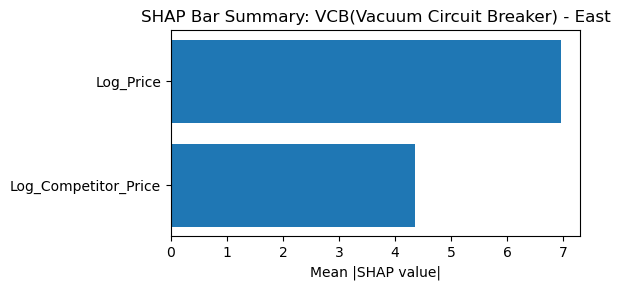

In [40]:
import pickle

product = 'VCB(Vacuum Circuit Breaker)'  # or whatever product you saved earlier
geography = 'East'                       # or the matching geography

# Load the model bundle
with open(f"models/model_{product}_{geography}.pkl", "rb") as f:
    bundle = pickle.load(f)

# Unpack the bundle
model_results = bundle['model_results']
exog_train = bundle['exog_train']
exog_test = bundle['exog_test']
exog_vars = bundle['exog_vars']
product = bundle['product']
geography = bundle['geography']

# Call SHAP explanation function
shap_df = generate_shap_explanation(
    exog_train=exog_train,
    exog_test=exog_test,
    model_results=model_results,
    exog_vars=exog_vars,
    product=product,
    geography=geography,
    sample_size=8
)


In [41]:
print(f"Test data rows available: {len(exog_test)}")


Test data rows available: 8



 Loading model_BBT(Busbar Trunking)_South.pkl
Test data rows: 1 for (BBT(Busbar Trunking), South)
 Skipping SHAP for (BBT(Busbar Trunking), South): only 1 rows

 Loading model_Starter_Central.pkl
Test data rows: 1 for (Starter, Central)
 Skipping SHAP for (Starter, Central): only 1 rows

 Loading model_E-House_Central.pkl
Test data rows: 11 for (E-House, Central)


  0%|          | 0/2 [00:00<?, ?it/s]

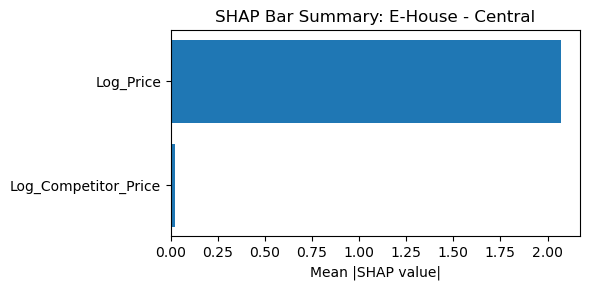


 Loading model_RMU(Ring Main Unit)_South.pkl
Test data rows: 13 for (RMU(Ring Main Unit), South)


  0%|          | 0/2 [00:00<?, ?it/s]

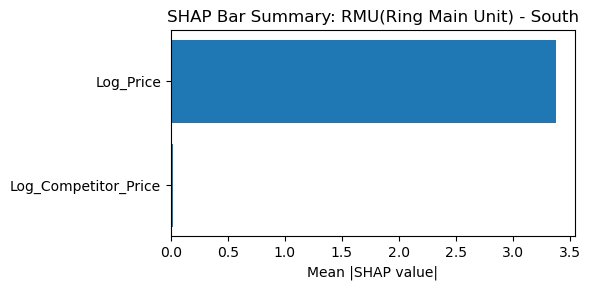


 Loading model_ACB(Air Circuit Breaker)_West.pkl
Test data rows: 8 for (ACB(Air Circuit Breaker), West)


  0%|          | 0/2 [00:00<?, ?it/s]

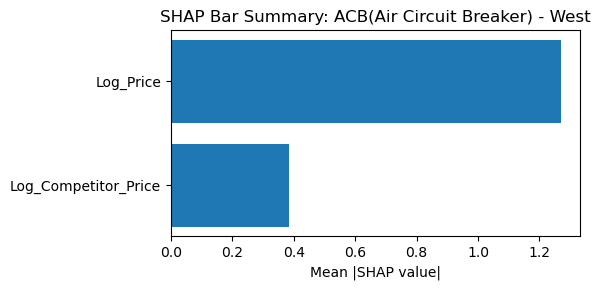


 Loading model_RMU(Ring Main Unit)_North.pkl
Test data rows: 13 for (RMU(Ring Main Unit), North)


  0%|          | 0/2 [00:00<?, ?it/s]

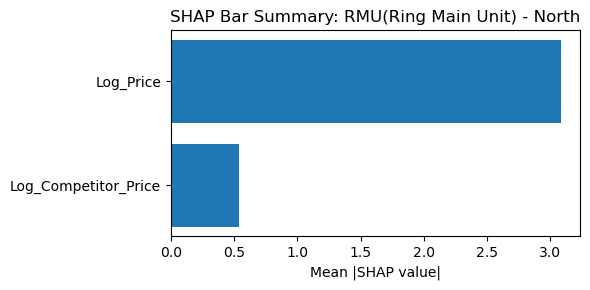


 Loading model_Modular Switches_East.pkl
Test data rows: 1 for (Modular Switches, East)
 Skipping SHAP for (Modular Switches, East): only 1 rows

 Loading model_ACB(Air Circuit Breaker)_North.pkl
Test data rows: 5 for (ACB(Air Circuit Breaker), North)


  0%|          | 0/2 [00:00<?, ?it/s]

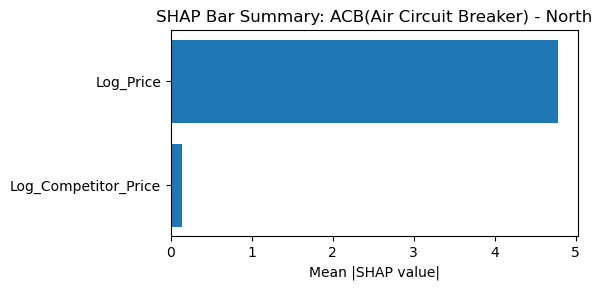


 Loading model_VCU(Vacuum Contactor Units)_South.pkl
Test data rows: 12 for (VCU(Vacuum Contactor Units), South)


  0%|          | 0/2 [00:00<?, ?it/s]

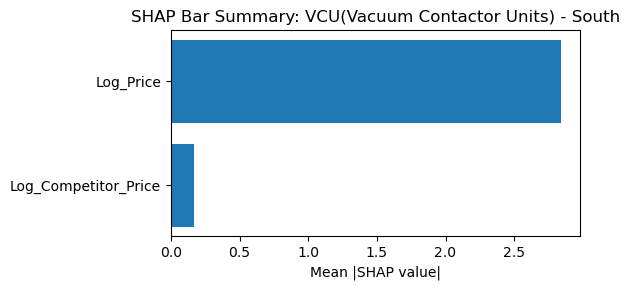


 Loading model_PSS(Compact Sub-Stations)_North.pkl
Test data rows: 13 for (PSS(Compact Sub-Stations), North)


  0%|          | 0/2 [00:00<?, ?it/s]

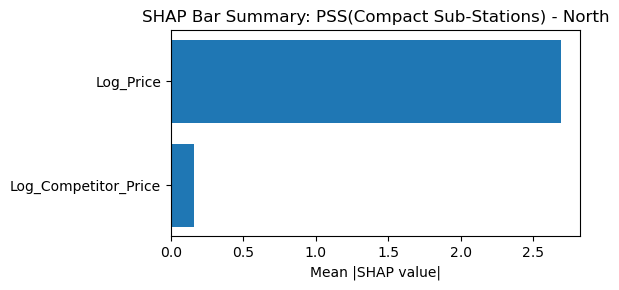


 Loading model_AIS(Air Insulated Switchgear)_Central.pkl
Test data rows: 13 for (AIS(Air Insulated Switchgear), Central)


  0%|          | 0/2 [00:00<?, ?it/s]

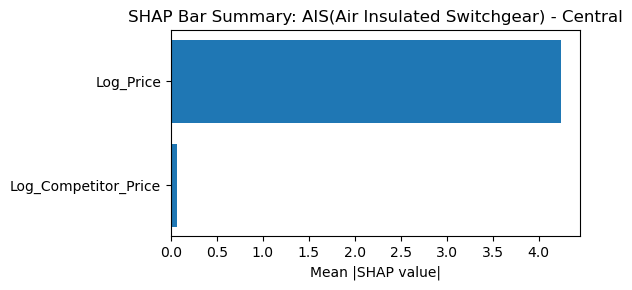


 Loading model_RMU(Ring Main Unit)_Central.pkl
Test data rows: 13 for (RMU(Ring Main Unit), Central)


  0%|          | 0/2 [00:00<?, ?it/s]

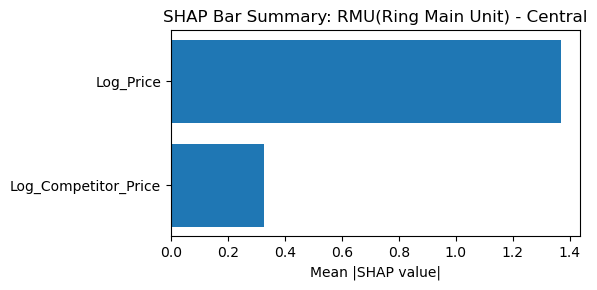


 Loading model_SDF(Switch Disconnectors)_North.pkl
Test data rows: 2 for (SDF(Switch Disconnectors), North)


  0%|          | 0/2 [00:00<?, ?it/s]

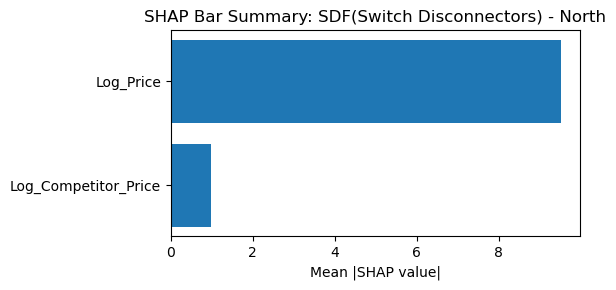


 Loading model_E-House_East.pkl
Test data rows: 12 for (E-House, East)


  0%|          | 0/2 [00:00<?, ?it/s]

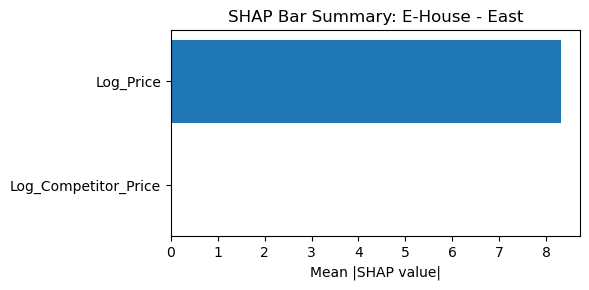


 Loading model_AIS(Air Insulated Switchgear)_North.pkl
Test data rows: 13 for (AIS(Air Insulated Switchgear), North)


  0%|          | 0/2 [00:00<?, ?it/s]

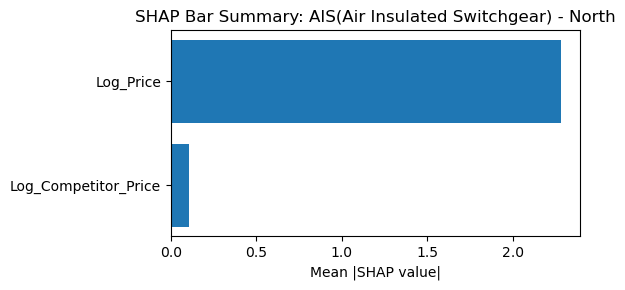


 Loading model_VCU(Vacuum Contactor Units)_East.pkl
Test data rows: 13 for (VCU(Vacuum Contactor Units), East)


  0%|          | 0/2 [00:00<?, ?it/s]

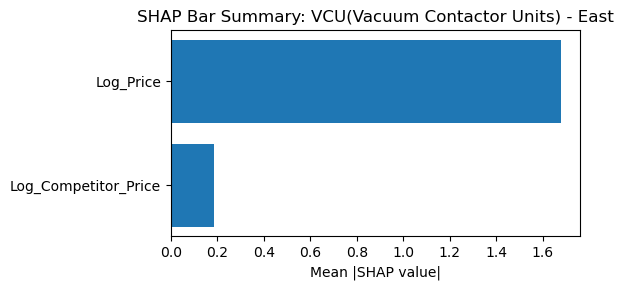


 Loading model_AIS(Air Insulated Switchgear)_East.pkl
Test data rows: 13 for (AIS(Air Insulated Switchgear), East)


  0%|          | 0/2 [00:00<?, ?it/s]

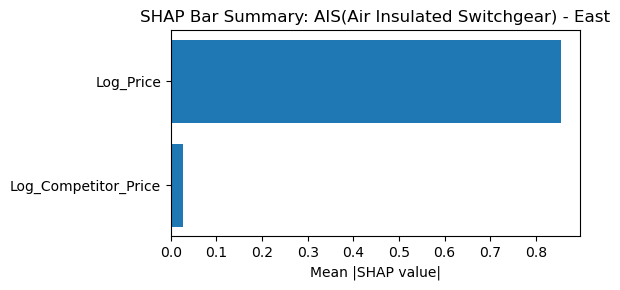


 Loading model_VCB(Vacuum Circuit Breaker)_East.pkl
Test data rows: 8 for (VCB(Vacuum Circuit Breaker), East)


  0%|          | 0/2 [00:00<?, ?it/s]

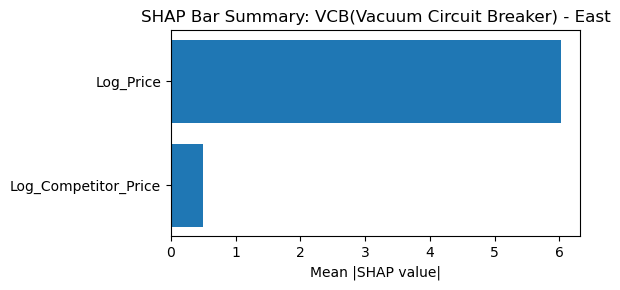


 Loading model_VCU(Vacuum Contactor Units)_North.pkl
Test data rows: 12 for (VCU(Vacuum Contactor Units), North)


  0%|          | 0/2 [00:00<?, ?it/s]

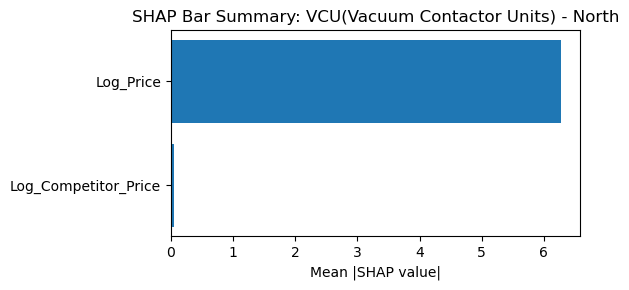


 Loading model_RMU(Ring Main Unit)_East.pkl
Test data rows: 13 for (RMU(Ring Main Unit), East)


  0%|          | 0/2 [00:00<?, ?it/s]

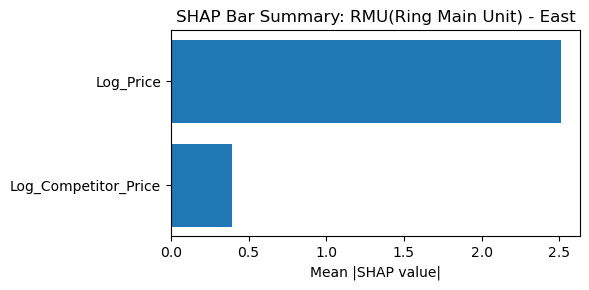


 Loading model_ACB(Air Circuit Breaker)_East.pkl
Test data rows: 7 for (ACB(Air Circuit Breaker), East)


  0%|          | 0/2 [00:00<?, ?it/s]

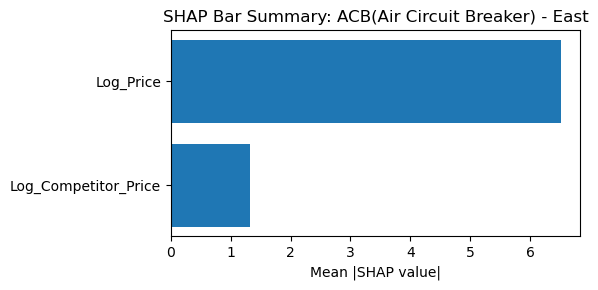


 Loading model_E-House_North.pkl
Test data rows: 13 for (E-House, North)


  0%|          | 0/2 [00:00<?, ?it/s]

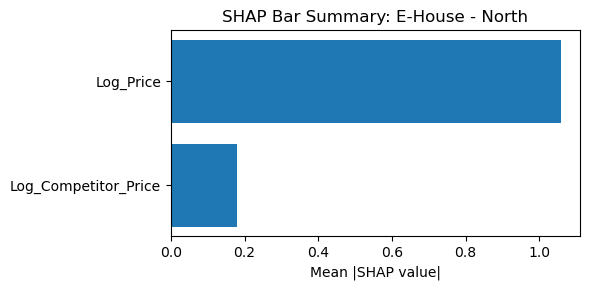


 Loading model_SDF(Switch Disconnectors)_South.pkl
Test data rows: 1 for (SDF(Switch Disconnectors), South)
 Skipping SHAP for (SDF(Switch Disconnectors), South): only 1 rows

 Loading model_SDF(Switch Disconnectors)_East.pkl
Test data rows: 2 for (SDF(Switch Disconnectors), East)


  0%|          | 0/2 [00:00<?, ?it/s]

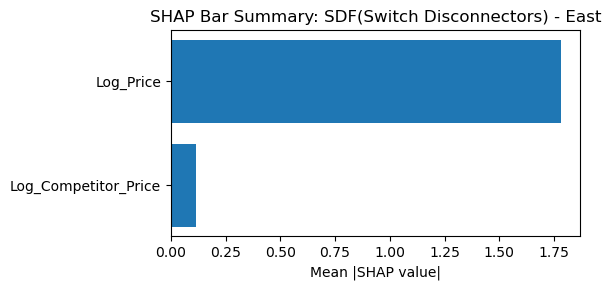


 Loading model_VCB(Vacuum Circuit Breaker)_West.pkl
Test data rows: 10 for (VCB(Vacuum Circuit Breaker), West)


  0%|          | 0/2 [00:00<?, ?it/s]

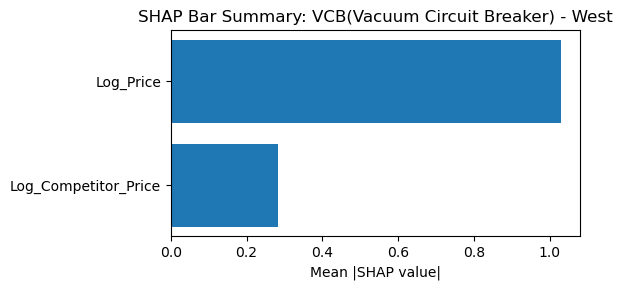


 Loading model_E-House_South.pkl
Test data rows: 11 for (E-House, South)


  0%|          | 0/2 [00:00<?, ?it/s]

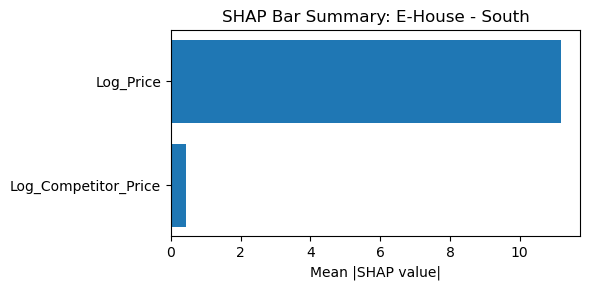


 Loading model_BBT(Busbar Trunking)_Central.pkl
Test data rows: 3 for (BBT(Busbar Trunking), Central)


  0%|          | 0/2 [00:00<?, ?it/s]

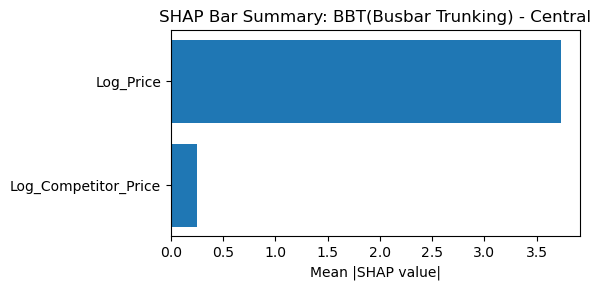


 Loading model_VCU(Vacuum Contactor Units)_West.pkl
Test data rows: 12 for (VCU(Vacuum Contactor Units), West)


  0%|          | 0/2 [00:00<?, ?it/s]

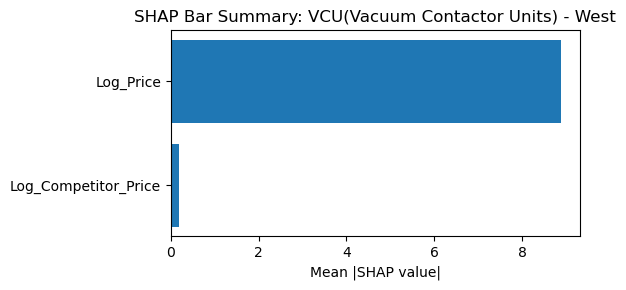


 Loading model_PSS(Compact Sub-Stations)_South.pkl
Test data rows: 13 for (PSS(Compact Sub-Stations), South)


  0%|          | 0/2 [00:00<?, ?it/s]

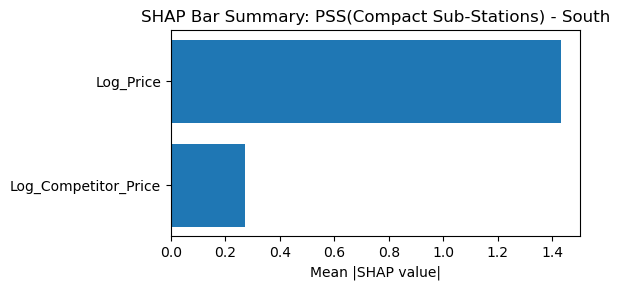


 Loading model_MCCB(Moduled Case Circuit Breaker)_West.pkl
Test data rows: 3 for (MCCB(Moduled Case Circuit Breaker), West)


  0%|          | 0/2 [00:00<?, ?it/s]

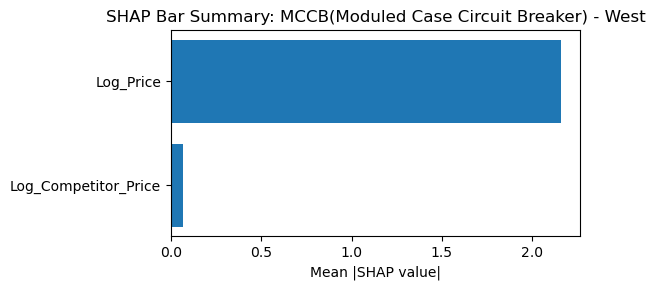


 Loading model_PSS(Compact Sub-Stations)_West.pkl
Test data rows: 13 for (PSS(Compact Sub-Stations), West)


  0%|          | 0/2 [00:00<?, ?it/s]

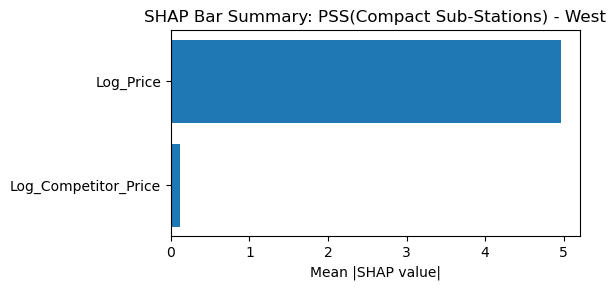


 Loading model_VCB(Vacuum Circuit Breaker)_Central.pkl
Test data rows: 10 for (VCB(Vacuum Circuit Breaker), Central)


  0%|          | 0/2 [00:00<?, ?it/s]

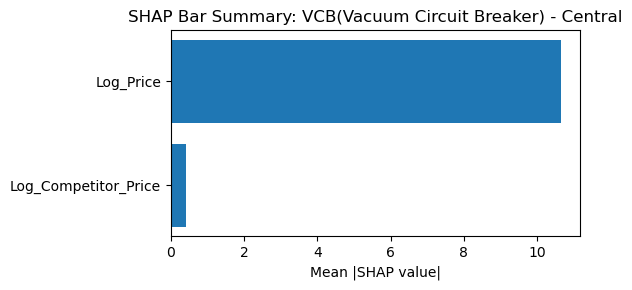


 Loading model_PSS(Compact Sub-Stations)_Central.pkl
Test data rows: 13 for (PSS(Compact Sub-Stations), Central)


  0%|          | 0/2 [00:00<?, ?it/s]

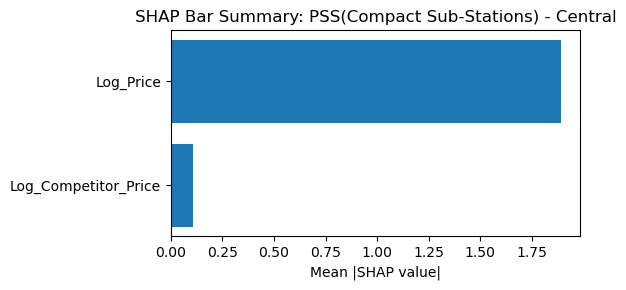


 Loading model_MCCB(Moduled Case Circuit Breaker)_East.pkl
Test data rows: 3 for (MCCB(Moduled Case Circuit Breaker), East)


  0%|          | 0/2 [00:00<?, ?it/s]

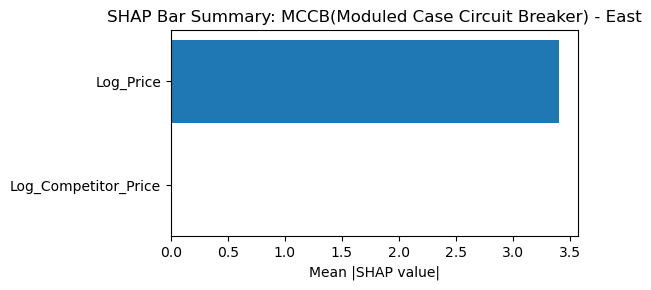


 Loading model_Starter_East.pkl
Test data rows: 1 for (Starter, East)
 Skipping SHAP for (Starter, East): only 1 rows

 Loading model_Modular Switches_North.pkl
Test data rows: 2 for (Modular Switches, North)


  0%|          | 0/2 [00:00<?, ?it/s]

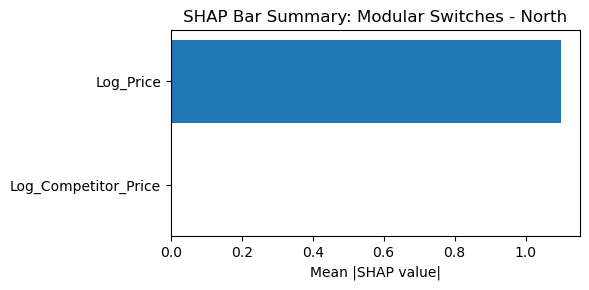


 Loading model_AIS(Air Insulated Switchgear)_South.pkl
Test data rows: 13 for (AIS(Air Insulated Switchgear), South)


  0%|          | 0/2 [00:00<?, ?it/s]

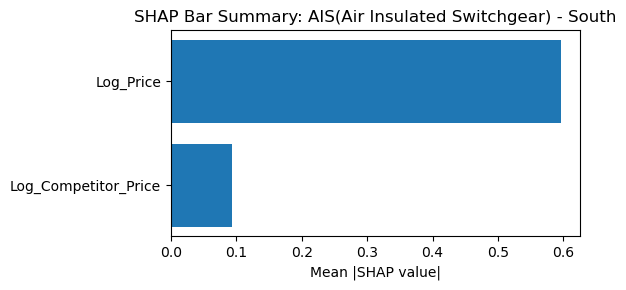


 Loading model_RMU(Ring Main Unit)_West.pkl
Test data rows: 13 for (RMU(Ring Main Unit), West)


  0%|          | 0/2 [00:00<?, ?it/s]

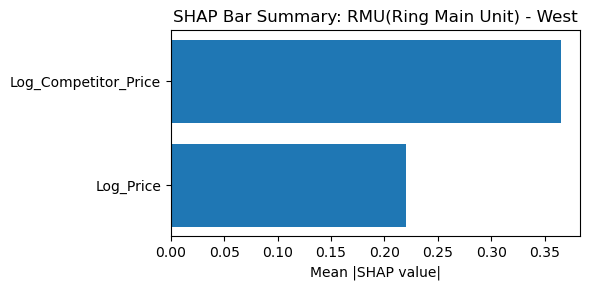


 Loading model_AIS(Air Insulated Switchgear)_West.pkl
Test data rows: 13 for (AIS(Air Insulated Switchgear), West)


  0%|          | 0/2 [00:00<?, ?it/s]

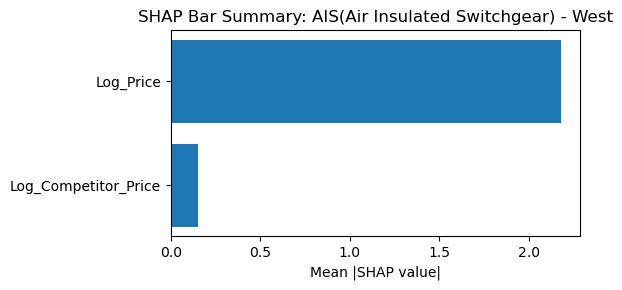


 Loading model_SDF(Switch Disconnectors)_Central.pkl
Test data rows: 2 for (SDF(Switch Disconnectors), Central)


  0%|          | 0/2 [00:00<?, ?it/s]

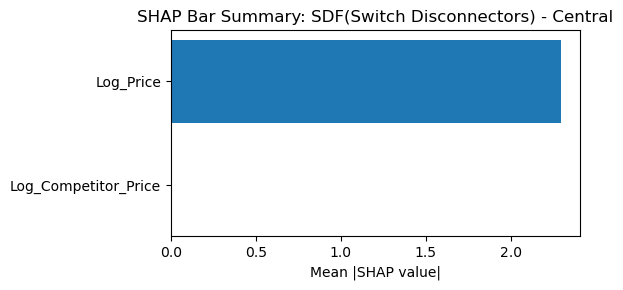


 Loading model_ACB(Air Circuit Breaker)_South.pkl
Test data rows: 3 for (ACB(Air Circuit Breaker), South)


  0%|          | 0/2 [00:00<?, ?it/s]

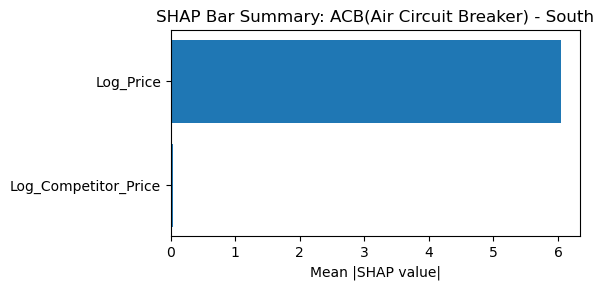


 Loading model_PSS(Compact Sub-Stations)_East.pkl
Test data rows: 13 for (PSS(Compact Sub-Stations), East)


  0%|          | 0/2 [00:00<?, ?it/s]

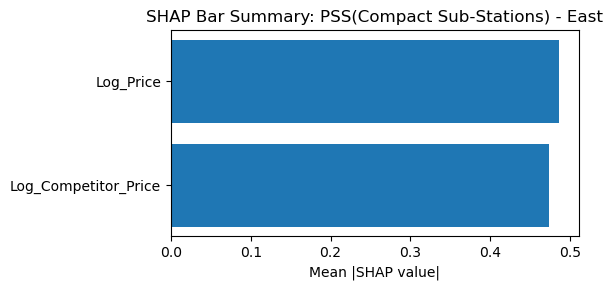


 Loading model_VCU(Vacuum Contactor Units)_Central.pkl
Test data rows: 12 for (VCU(Vacuum Contactor Units), Central)


  0%|          | 0/2 [00:00<?, ?it/s]

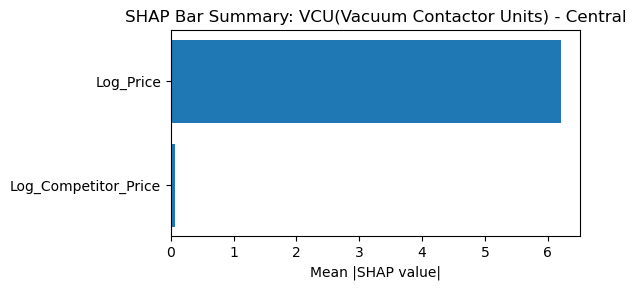


 Loading model_VCB(Vacuum Circuit Breaker)_North.pkl
Test data rows: 10 for (VCB(Vacuum Circuit Breaker), North)


  0%|          | 0/2 [00:00<?, ?it/s]

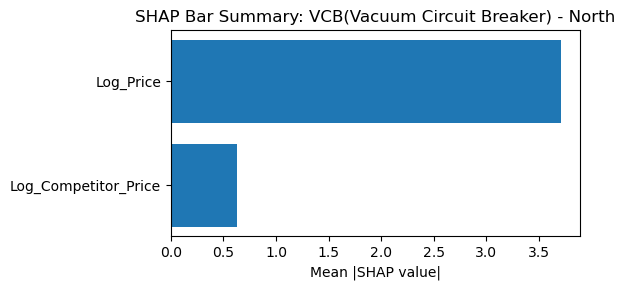


 Loading model_Modular Switches_West.pkl
Test data rows: 1 for (Modular Switches, West)
 Skipping SHAP for (Modular Switches, West): only 1 rows

 Loading model_MCCB(Moduled Case Circuit Breaker)_South.pkl
Test data rows: 4 for (MCCB(Moduled Case Circuit Breaker), South)


  0%|          | 0/2 [00:00<?, ?it/s]

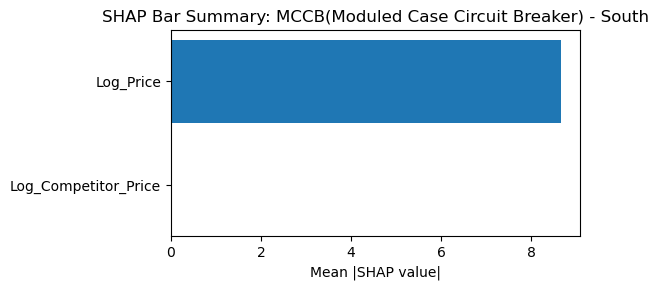


 Loading model_E-House_West.pkl
Test data rows: 11 for (E-House, West)


  0%|          | 0/2 [00:00<?, ?it/s]

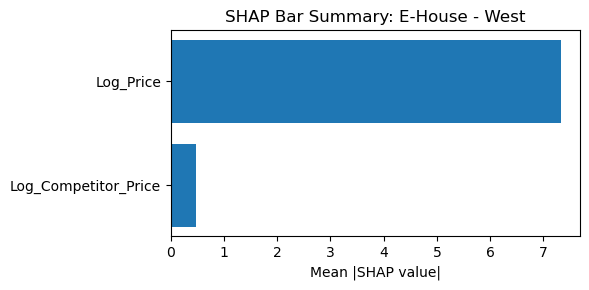


 Loading model_MCCB(Moduled Case Circuit Breaker)_North.pkl
Test data rows: 6 for (MCCB(Moduled Case Circuit Breaker), North)


  0%|          | 0/2 [00:00<?, ?it/s]

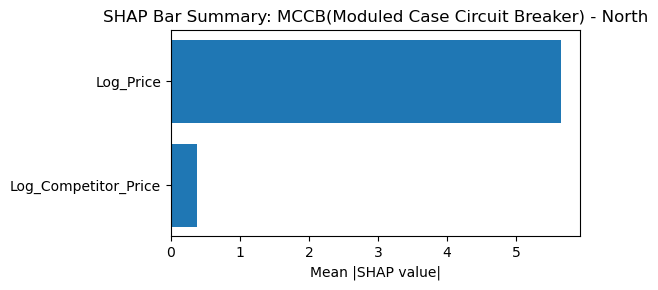


 Loading model_VCB(Vacuum Circuit Breaker)_South.pkl
Test data rows: 9 for (VCB(Vacuum Circuit Breaker), South)


  0%|          | 0/2 [00:00<?, ?it/s]

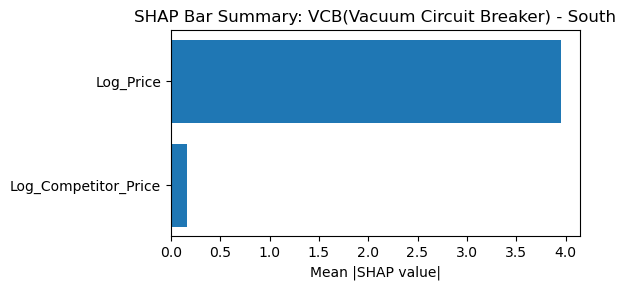


 Loading model_ACB(Air Circuit Breaker)_Central.pkl
Test data rows: 4 for (ACB(Air Circuit Breaker), Central)


  0%|          | 0/2 [00:00<?, ?it/s]

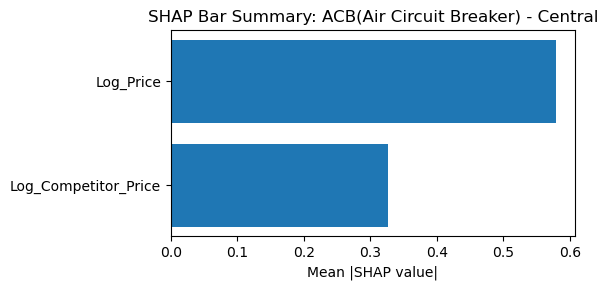

In [42]:
import os
import pickle

# List all pkl files
model_files = [f for f in os.listdir("models") if f.endswith(".pkl")]

for file in model_files:
    print(f"\n Loading {file}")

    with open(os.path.join("models", file), "rb") as f:
        loaded = pickle.load(f)

    # CASE 1: Full model bundle (dict with all components)
    if isinstance(loaded, dict):
        model_results = loaded['model_results']
        exog_train = loaded['exog_train']
        exog_test = loaded['exog_test']
        exog_vars = loaded['exog_vars']
        product = loaded['product']
        geography = loaded['geography']
    # CASE 2: Only model was saved (fallback)
    else:
        print(f"Skipping {file} — not a model bundle (no SHAP inputs)")
        continue

    print(f"Test data rows: {len(exog_test)} for ({product}, {geography})")

    if len(exog_test) >= 2:
        shap_df = generate_shap_explanation(
            exog_train=exog_train,
            exog_test=exog_test,
            model_results=model_results,
            exog_vars=exog_vars,
            product=product,
            geography=geography,
            sample_size=2
        )
    else:
        print(f" Skipping SHAP for ({product}, {geography}): only {len(exog_test)} rows")


In [43]:
# Create folder once for all SHAP plots
os.makedirs("shap_outputs", exist_ok=True)
